/usr/local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


🔧 [DEV MODE] 개발 모드 활성화:
   - 직원 수: 1000명
   - 날짜 범위: 2020-01-01 ~ 현재
   - 예상 로딩 속도: 프로덕션 수준 (대용량 데이터)


/app/src/services/tables/Time_Attendance/detailed_working_info_table.py:80: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['IS_VACATION'] = df['IS_VACATION'].fillna(False).astype(bool)
/app/src/services/tables/create_ml_table.py:351: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  eval_trend = eval_df.groupby('EMP_ID').apply(calculate_trend).reset_index(name='EVAL_SCORE_TREND')
/usr/local/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [07:50:41] WARNING: /workspace/

✅ 폰트 설정: NanumGothic (Linux/Docker)
조정된 데이터 비율 (퇴사자:재직자) = 1 : 6
예상 Base Value: 14.3%

--- [분석 대상: 퇴사 위험 1위] ---
사번: E00826
예측된 퇴사 위험도: 73.8%
Base Value (평균 퇴사율): 25.69%


/usr/local/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)


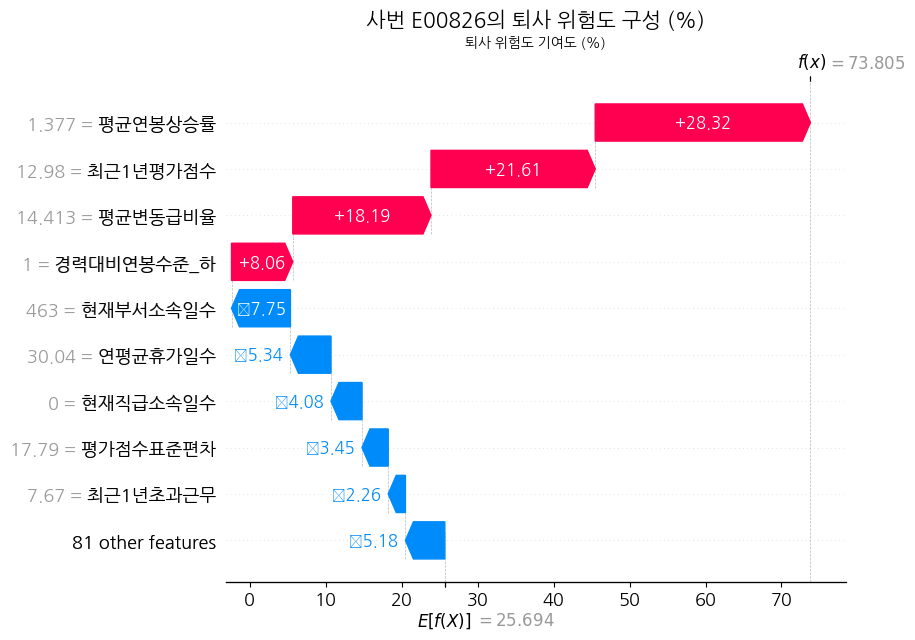

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import shap
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import os

from services.tables.create_ml_table import master_df_encoded

# --- 1. 한글 폰트 설정 (Docker 환경 대응) ---
def set_korean_font():
    # 사용 가능한 폰트 리스트 확인
    font_names = [f.name for f in fm.fontManager.ttflist]
    
    # 1순위: 나눔고딕 (Linux/Docker 표준), 2순위: 맑은 고딕 (Windows), 3순위: 애플고딕 (Mac)
    if 'NanumGothic' in font_names:
        plt.rcParams['font.family'] = 'NanumGothic'
        print("✅ 폰트 설정: NanumGothic (Linux/Docker)")
    elif 'Malgun Gothic' in font_names:
        plt.rcParams['font.family'] = 'Malgun Gothic'
        print("✅ 폰트 설정: Malgun Gothic (Windows)")
    elif 'AppleGothic' in font_names:
        plt.rcParams['font.family'] = 'AppleGothic'
        print("✅ 폰트 설정: AppleGothic (Mac)")
    else:
        # 폰트가 없을 경우 경고 메시지 출력 및 영어 설정 (깨짐 방지)
        print("⚠️ 한글 폰트를 찾을 수 없습니다. Docker에서 'apt-get install -y fonts-nanum'을 실행해주세요.")
        print("   (임시로 영문 폰트를 사용합니다.)")
        plt.rcParams['font.family'] = 'DejaVu Sans' # 기본 영문 폰트

set_korean_font()
plt.rcParams['axes.unicode_minus'] = False

# --- 2. 데이터 준비 ---

# 데이터 타입 정리
for col in master_df_encoded.columns:
    if master_df_encoded[col].dtype == 'object' and col not in ['사번', '재직여부', '퇴사자여부']:
        master_df_encoded[col] = pd.to_numeric(master_df_encoded[col], errors='coerce')
master_df_encoded.fillna(master_df_encoded.median(numeric_only=True), inplace=True)

# --------------------------------------------------------------------------------
# [Step 1] 데이터 비율 9:1 만들기 (Base Value를 낮추기 위함)
# --------------------------------------------------------------------------------
df_leavers = master_df_encoded[master_df_encoded['퇴사자여부'] == 1]
df_active = (master_df_encoded[(master_df_encoded['퇴사자여부'] == 0) & (master_df_encoded["재직일수"] >= 182)]
)

n_leavers = len(df_leavers)
n_required_active = n_leavers * 6 # 1:6 비율

# 재직자 뻥튀기 (Oversampling)
df_active_oversampled = df_active.sample(n=n_required_active, replace=True, random_state=42)

# 학습 데이터 생성
balanced_df = pd.concat([df_leavers, df_active_oversampled], axis=0).sample(frac=1, random_state=42).reset_index(drop=True)

print(f"조정된 데이터 비율 (퇴사자:재직자) = 1 : {len(df_active_oversampled)/len(df_leavers):.0f}")
print(f"예상 Base Value: {balanced_df['퇴사자여부'].mean()*100:.1f}%")

# --------------------------------------------------------------------------------

drop_cols = ['사번', '재직여부', '퇴사자여부']
feature_cols = [col for col in balanced_df.columns if col not in drop_cols]

X_train = balanced_df[feature_cols].astype(float)
y_train = balanced_df['퇴사자여부'].astype(float)

# --------------------------------------------------------------------------------
# [Step 2] 핵심: scale_pos_weight 설정 (확률을 뻥튀기하기 위함)
# --------------------------------------------------------------------------------
# 퇴사자(1)에 대한 가중치를 높여서, 조금만 징후가 보여도 확률을 높게 예측하게 함
# 보통 '음성 클래스 수 / 양성 클래스 수'로 설정하지만, '보여주기'를 위해 값을 더 높여도 됨
weight_ratio = 70  # (6:1 불균형을 상쇄할 만큼의 힘)

model = xgb.XGBClassifier(
    n_estimators=weight_ratio, 
    max_depth=2,             
    learning_rate=0.1, 
    scale_pos_weight=weight_ratio,  # <--- [핵심] 이 값이 높을수록 퇴사 확률이 높게 나옴
    random_state=42, 
    min_child_weight=10, 
    use_label_encoder=False, 
    eval_metric='logloss'
)
model.fit(X_train, y_train)
# --------------------------------------------------------------------------------

# --- 4. 고위험군(1위) 선정 (원본 데이터에서 탐색) ---
active_employees_original = master_df_encoded[(master_df_encoded['재직여부'] == 'Y') & (master_df_encoded['재직일수'] >= 182)].copy()

if active_employees_original.empty:
    print("분석할 재직자가 없습니다.")
else:
    X_active_real = active_employees_original[feature_cols].astype(float)
    probs = model.predict_proba(X_active_real)[:, 1]
    
    active_employees_original['PREDICTED_RISK'] = probs
    sorted_risk_df = active_employees_original.sort_values(by='PREDICTED_RISK', ascending=False)
    
    top_risk_emp = sorted_risk_df.iloc[0]
    top_emp_id = top_risk_emp['사번']
    top_risk_score = top_risk_emp['PREDICTED_RISK']

    print(f"\n--- [분석 대상: 퇴사 위험 1위] ---")
    print(f"사번: {top_emp_id}")
    print(f"예측된 퇴사 위험도: {top_risk_score*100:.1f}%")

    # --- 5. SHAP 분석 ---
    target_X_numpy = X_active_real.loc[[top_risk_emp.name]].values
    
    # 배경 데이터: 학습 데이터에서 샘플링 (여기 비율도 9:1이므로 Base Value는 낮게 유지됨)
    background_data = shap.sample(X_train, 100)

    explainer = shap.TreeExplainer(
        model, 
        data=background_data, 
        feature_perturbation="interventional",
        model_output="probability"
    )
    
    shap_values = explainer(target_X_numpy)
    
    # % 변환
    shap_values.values = shap_values.values * 100
    shap_values.base_values = shap_values.base_values * 100
    
    print(f"Base Value (평균 퇴사율): {shap_values.base_values[0]:.2f}%")

    plt.figure(figsize=(10, 6))
    shap.plots.waterfall(
        shap_values[0],
        max_display=10,
        show=False
    )
    plt.title(f"사번 {top_emp_id}의 퇴사 위험도 구성 (%)", fontsize=15)
    plt.xlabel("퇴사 위험도 기여도 (%)")
    plt.show()

In [2]:
sorted_risk_df['PREDICTED_RISK'].round(2)

825    0.74
421    0.73
880    0.66
793    0.64
813    0.56
       ... 
293    0.02
38     0.02
235    0.02
453    0.02
935    0.02
Name: PREDICTED_RISK, Length: 461, dtype: float32

In [3]:
sorted_risk_df['PREDICTED_RISK'].round(2).head(20)

825    0.74
421    0.73
880    0.66
793    0.64
813    0.56
82     0.50
719    0.50
140    0.49
416    0.45
744    0.41
510    0.40
9      0.40
464    0.39
944    0.39
162    0.39
721    0.38
868    0.38
102    0.35
922    0.35
988    0.35
Name: PREDICTED_RISK, dtype: float32